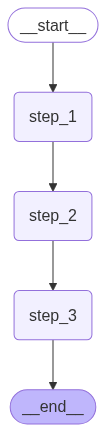

In [31]:
from IPython.display import Image, display

from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import NodeInterrupt
from langgraph.graph import START, END, StateGraph

class State(TypedDict):
    input:str

def step_1(state: State) -> State:
    print("----Step 1----")
    return state

def step_2(state: State) -> State:
    # Let's optionally raise a NodeInterrupt if the length of the input is longer than 5 characters
    if len(state['input']) > 5:
        raise NodeInterrupt(
            f"Received input that is longer than 5 characters: {state['input']}")

    print("---Step 2---")
    return state

def step_3(state: State) -> State:
    print("---Step 3---")
    return state


builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Compile the graph with memory
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [32]:
initial_input = {"input": "hello world"}
thread_config = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread_config, stream_mode="values"):
    print(event)

{'input': 'hello world'}
----Step 1----
{'input': 'hello world'}
{'__interrupt__': (Interrupt(value='Received input that is longer than 5 characters: hello world', resumable=False, ns=None),)}


In [33]:
state = graph.get_state(thread_config)
state.next

('step_2',)

In [34]:
print(state.tasks)

(PregelTask(id='e60af25e-96ac-376e-f1d6-88e31dff9fc4', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(Interrupt(value='Received input that is longer than 5 characters: hello world', resumable=False, ns=None),), state=None, result=None),)


####

In [35]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'input': 'hello world'}
{'__interrupt__': (Interrupt(value='Received input that is longer than 5 characters: hello world', resumable=False, ns=None),)}


In [36]:
graph.update_state(
    thread_config,
    {"input": "hi"},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f045de7-db9e-6c2f-8002-75d4c08c9435'}}

In [37]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'input': 'hi'}
---Step 2---
{'input': 'hi'}
---Step 3---
{'input': 'hi'}
